In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize
from anndata import AnnData
import anndata
from sklearn.utils import shuffle
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import anndata as ad
import importlib
import PlotConfusion as pc
importlib.reload(pc)
import PlotConfusion as pc
import matplotlib as mpl

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=160, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [3]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams.update({'axes.labelsize' : 16}) 

In [4]:
def plot_multidotplot(adatas, cmaps, groupby, group_order, gene_order, stack='v', vmin=0, vmax=2, dot_min=0, dot_max=1, adata_names=None, save='multidotplot.png', size_exp=1.5, vline_locs=[]):
    adatas = list(reversed(adatas))
    cmaps = list(reversed(cmaps))
    num_adatas = len(adatas)

    if isinstance(adata_names, type(None)):
        adata_names = [str(i+1) for i in range(num_adatas)]
    else:
        if len(adata_names) != num_adatas:
            raise Exception('adata_names does not match the length of adatas')
        adata_names = list(reversed([str(i) for i in adata_names]))

    mean_dfs = []
    dot_size_dfs = []
    for i in range(num_adatas):
        adata = adatas[i]
        genedf = sc.get.obs_df(
            adata,
            keys=[groupby, *gene_order],
            use_raw=True
        )
        grouped = genedf.groupby(groupby, observed=True)
        mean_df = grouped.mean()
        
        genedf_bool = genedf.copy()
        genedf_bool[gene_order] = genedf[gene_order] > 0
        dot_size_df = genedf.copy()
        dot_size_df = genedf_bool.groupby(groupby, observed=True).sum()/genedf_bool.groupby(groupby, observed=True).count()

        mean_dfs.append(mean_df)
        dot_size_dfs.append(dot_size_df)

    xs = []
    ys = []
    if stack == 'v':
        for i in range(num_adatas):
            xs_single = []
            ys_single = []
            for j in range(len(gene_order)):
                ys_single.append((num_adatas*(j+1)-(num_adatas-i-1))*np.ones(len(group_order)))
                xs_single.append(np.ones(len(group_order))+np.arange(len(group_order)))
            xs.append(xs_single)
            ys.append(ys_single)
    elif stack == 'h':
        for i in range(num_adatas):
            xs_single = []
            ys_single = []
            for j in range(len(gene_order)):
                ys_single.append((j+1)*np.ones(len(group_order)))
                xs_single.append((i+1)*np.ones(len(group_order))+num_adatas*np.arange(len(group_order)))
            xs.append(xs_single)
            ys.append(ys_single)
        xs = list(reversed(xs))
    else:
        raise Exception('stack must be \'v\' or \'h\'')

    if stack == 'v':
        fig_width = len(group_order)/3
        fig_height = num_adatas*len(gene_order)/3
    elif stack == 'h':
        fig_width = num_adatas*len(group_order)/3
        fig_height = len(gene_order)/3

    fig, ax = plt.subplots(figsize=(fig_width,fig_height))

    for i in range(num_adatas):
        colors = np.flip(mean_dfs[i].T[group_order].to_numpy(), axis=0).flatten()
        sizes = 200*np.flip(dot_size_dfs[i].T[group_order].to_numpy(), axis=0).flatten()**size_exp
        plt.scatter(xs[i], ys[i], c=colors, cmap=cmaps[i], s=sizes, vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.2)
    if stack == 'v':
        plt.xticks(np.arange(len(group_order))+1, group_order, rotation=90)
        label_locs = list(np.arange(0, num_adatas*len(gene_order), num_adatas)+(num_adatas+1)/2)
        labels = list(reversed(gene_order))
        for i in np.arange(num_adatas*len(gene_order))+1:
            if i not in label_locs:
                label_locs.append(i)
                labels.append('')
        plt.yticks(label_locs, labels)
        plt.xlim([0,len(group_order)+1])
        plt.ylim([0,num_adatas*len(gene_order)+1])
        plt.vlines(vline_locs, 0, num_adatas*len(gene_order)+1, color='black', ls='dashed')
        for i in np.arange(len(gene_order)):
            y0 = num_adatas*i+1
            y1 = num_adatas*(i+1)
            line = plt.plot([-0.2, -0.2], [y0, y1], linewidth = 1, color='black')
            line[0].set_clip_on(False)
    elif stack == 'h':
        label_locs = list(np.arange(0, num_adatas*len(group_order), num_adatas)+(num_adatas+1)/2)
        labels = group_order.copy()
        for i in np.arange(num_adatas*len(group_order))+1:
            if i not in label_locs:
                label_locs.append(i)
                labels.append('')
        plt.xticks(label_locs, labels, rotation=90)
        plt.yticks(np.arange(len(gene_order))+1, list(reversed(gene_order)))
        plt.xlim([0,num_adatas*len(group_order)+1])
        plt.ylim([0,len(gene_order)+1])
        plt.vlines(vline_locs, 0, len(gene_order)+1, color='black', ls='dashed')
        for i in np.arange(len(group_order)):
            x0 = num_adatas*i+1
            x1 = num_adatas*(i+1)
            line = plt.plot([x0, x1], [-0.2, -0.2], linewidth = 1, color='black')
            line[0].set_clip_on(False)
    plt.grid(False)

    num_legend_dots = 5
    size_pos = np.arange(num_legend_dots)
    size_sizes = np.arange(0.2, 1.01, 0.2)
    pos = ax.get_position()
    size_ax = fig.add_axes([pos.x1+0.225/fig_width, pos.y0+0.3/fig_height, 1.65/fig_width, 0.3/fig_height])
    size_ax.grid(False)
    size_ax.spines["right"].set_visible(False)
    size_ax.spines["top"].set_visible(False)
    size_ax.spines["left"].set_visible(False)
    size_ax.spines["bottom"].set_visible(False)
    size_ax.tick_params(axis="y", left=False, labelleft=False, labelright=False)
    size_ax.scatter(size_pos, len(size_pos)*[0], s=200*size_sizes**size_exp, color='gray', edgecolor='black', linewidth=0.2)
    size_ax.set_xlim([-1, num_legend_dots])
    size_ax.set_xticks(size_pos, [round(100*i) for i in size_sizes])
    size_ax.set_title("Fraction of cells\nin group (%)")

    size_pos = size_ax.get_position()
    current_y_pos = size_pos.y1
    for i in range(num_adatas):
        color_ax = fig.add_axes([size_pos.x0, current_y_pos+0.9/fig_height, 1.65/fig_width, 0.15/fig_height])
        cbar = mpl.colorbar.ColorbarBase(color_ax, cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), orientation='horizontal')
        color_ax.set_title("Mean expression\nin " + adata_names[i])
        current_y_pos = color_ax.get_position().y1

    plt.savefig(save, bbox_inches='tight')

In [5]:
def run_umap(adata, harmony_key=None):
    sc.pp.scale(adata, max_value=10)
    np.nan_to_num(adata.X, copy=False)
    sc.tl.pca(adata, svd_solver='arpack')
    if harmony_key != None:
        Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = harmony_key)
        adata.obsm['X_harmony'] = Z
        sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_harmony', knn=True)
    else:
        sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca', knn=True)
    sc.tl.umap(adata)

In [19]:
adata_p7 = sc.read_h5ad('adatas/P7_adata_classified.h5ad')
adata_p7b2 = sc.read_h5ad('adatas/P7b2_adata_classified.h5ad')

In [50]:
adata_p7.obs

,Batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_raw,leiden,Cluster,Class,Condition_class
AAACCCAAGAAAGTCT-1_1,Batch1,4249,425,396.689117,464.0,2.891686,16046.0,36,37,RGC,Control_RGC
AAACCCACACATATCG-1_1,Batch1,4897,584,623.034485,631.0,4.255176,14829.0,3,4,RGC,Control_RGC
AAACCCACAGTCGAGA-1_1,Batch1,4948,522,482.313538,698.0,3.752083,18603.0,11,12,RGC,Control_RGC
AAACCCACATAGACTC-1_1,Batch1,3855,554,702.246704,861.0,8.182077,10523.0,25,26,RGC,Control_RGC
AAACCCACATCATCTT-1_1,Batch1,4499,593,656.244141,412.0,3.323653,12396.0,7,8,RGC,Control_RGC
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTATGAGAT-1_3,Batch3,2695,314,433.332947,195.0,3.257601,5986.0,1,2,RGC,Control_RGC
TTTGTTGGTCATAACC-1_3,Batch3,3305,393,438.872253,373.0,4.064509,9177.0,15,16,RGC,Control_RGC
TTTGTTGTCATGCCAA-1_3,Batch3,2660,352,449.527069,207.0,3.306181,6261.0,0,1,RGC,Control_RGC
TTTGTTGTCGCATGAT-1_3,Batch3,4080,460,477.146881,399.0,3.154150,12650.0,11,12,RGC,Control_RGC


In [21]:
condition_class = []
for i in adata_p7.obs['Class']:
    condition_class.append("Control_" + i)
adata_p7.obs['Condition_class'] = pd.Categorical(condition_class)

In [22]:
condition_class = []
for i in adata_p7b2.obs['Class']:
    condition_class.append("β2-KO_" + i)
adata_p7b2.obs['Condition_class'] = pd.Categorical(condition_class)

In [25]:
class_order = ['RGC', 'GABA-AC', 'BC', 'Müller_Glia', 'Endo', 'Microglia']

In [26]:
class_markers = ['Slc17a6', 'Rbpms', 'Pou4f1', 'Pou4f2', 'Pou4f3', 'Tfap2a', 'Gad1', 'Vsx2', 'Otx2', 'Rlbp1', 'Kcnj8', 'Fcrls', 'P2ry12', 'Chrnb2']

In [27]:
adata_p7_pruned = adata_p7[~adata_p7.obs['Class'].isin(['Debris', 'Doublet'])]
adata_p7b2_pruned = adata_p7b2[~adata_p7b2.obs['Class'].isin(['Debris', 'Doublet'])]

In [28]:
adata_combined_pruned = ad.concat([adata_p7_pruned, adata_p7b2_pruned], label='Condition', keys=['Control', 'β2-KO'])

C:\Users\pomat\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


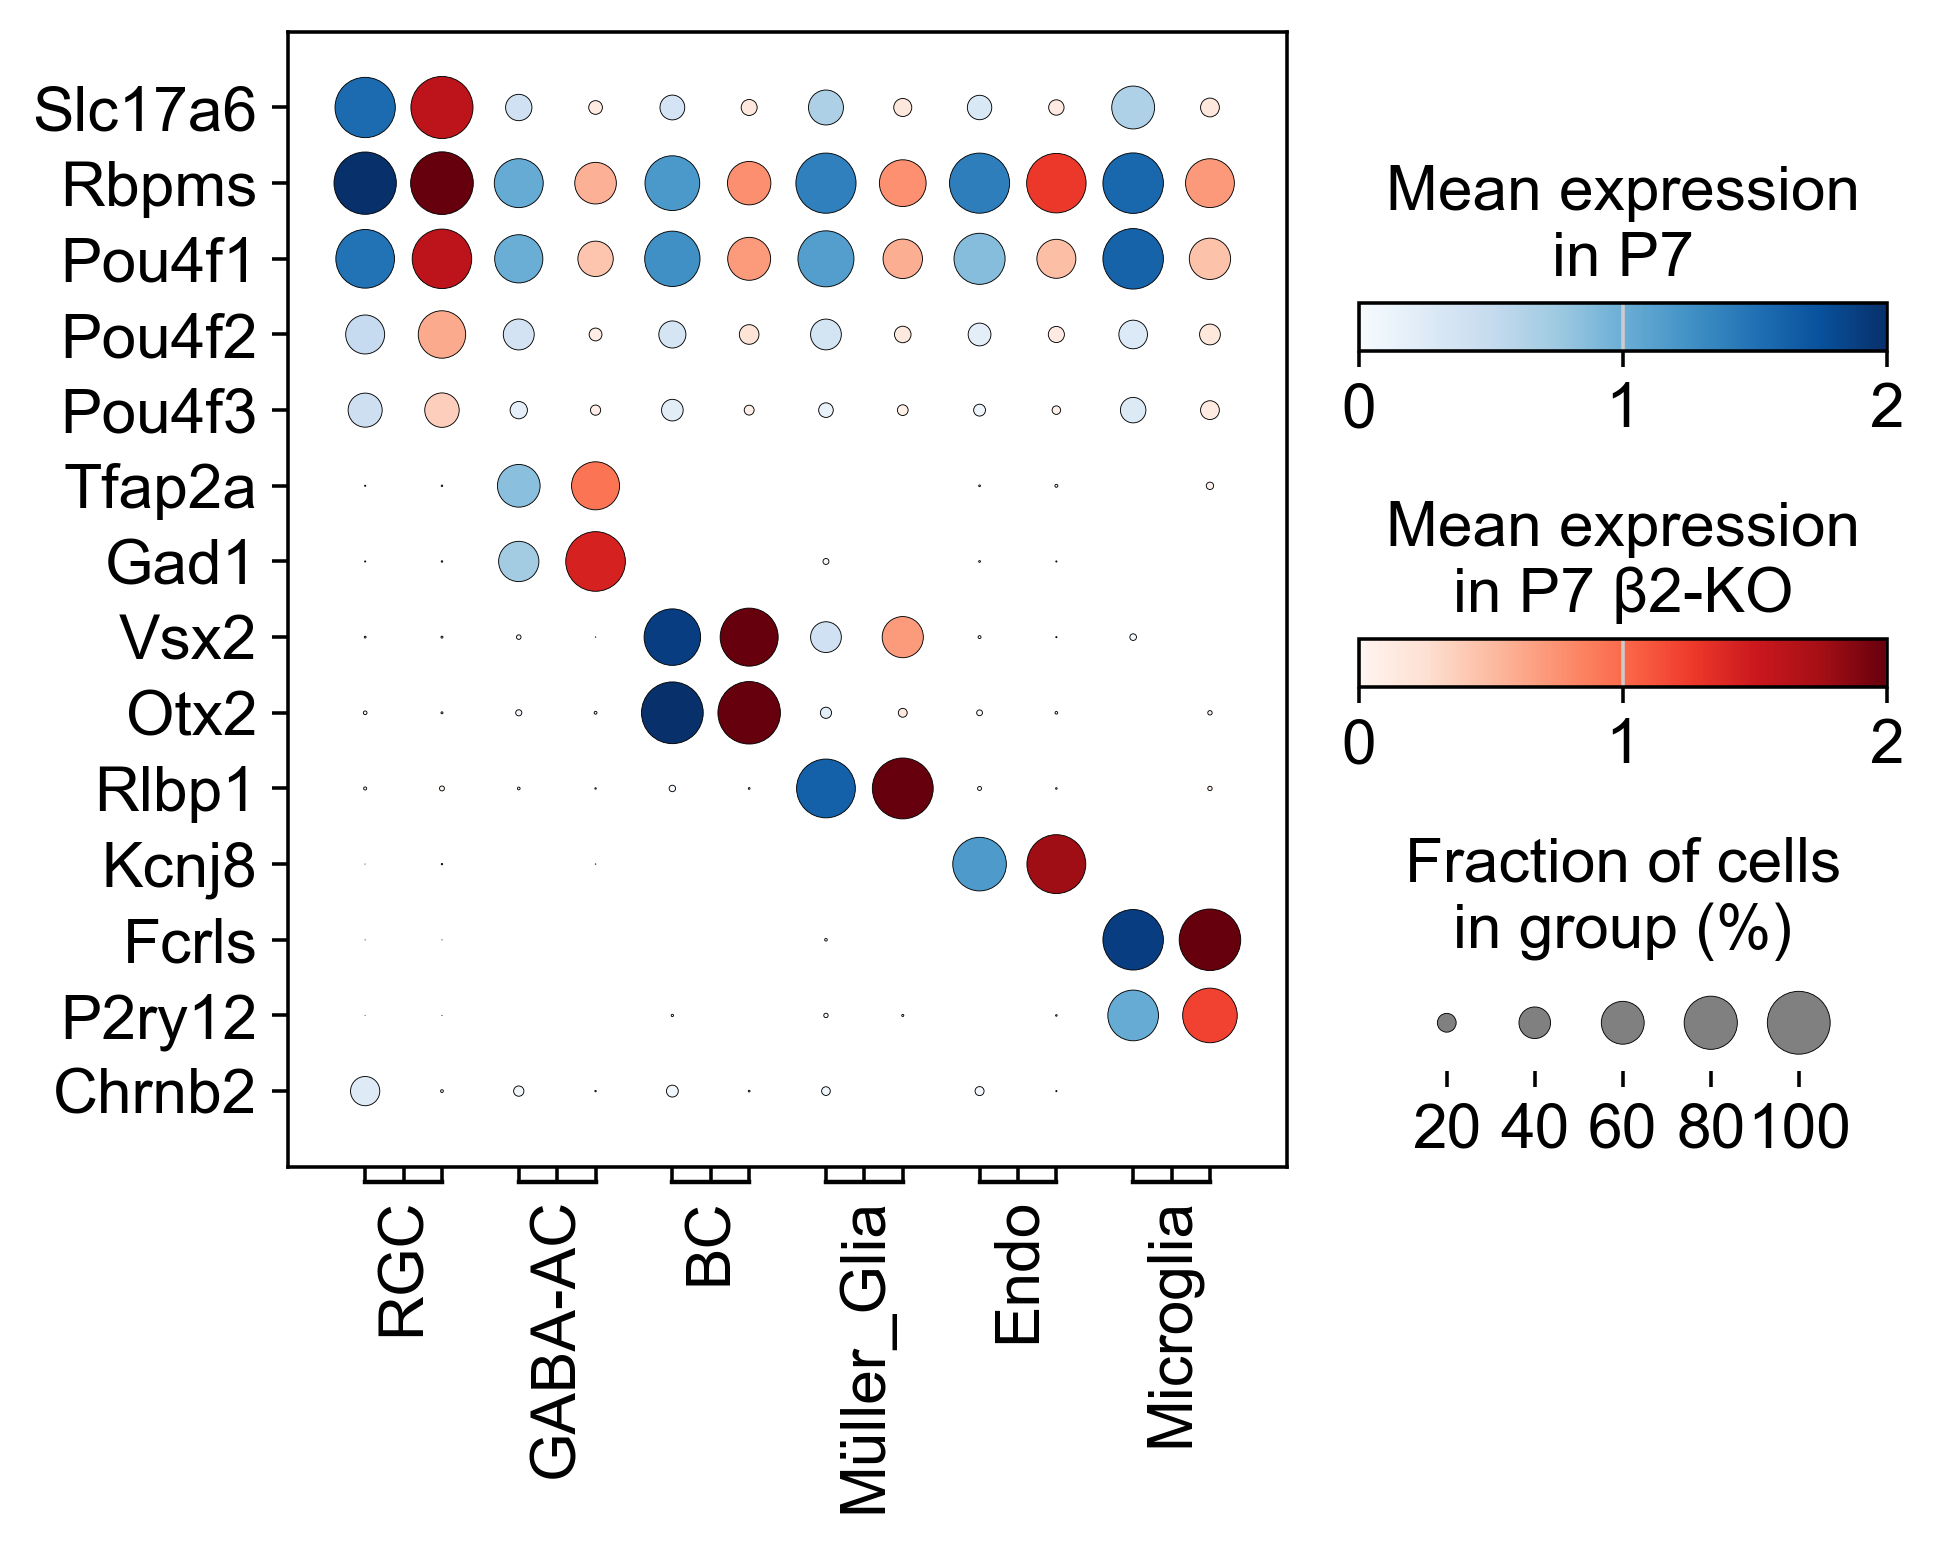

In [31]:
plot_multidotplot([adata_p7_pruned, adata_p7b2_pruned], ['Blues', 'Reds'], groupby='Class', group_order=class_order, gene_order=class_markers, adata_names=['P7', 'P7 β2-KO'], stack='h', save='fig1_dotplot.svg')

In [32]:
control_class_pcts = []
b2_class_pcts = []
for i in ['RGC', 'GABA-AC', 'BC', 'Müller_Glia', 'Endo', 'Microglia']:
    control_class_pcts.append(len(adata_p7_pruned[adata_p7_pruned.obs['Class'] == i].obs)/len(adata_p7_pruned.obs))
    b2_class_pcts.append(len(adata_p7b2_pruned[adata_p7b2_pruned.obs['Class'] == i].obs)/len(adata_p7b2_pruned.obs))

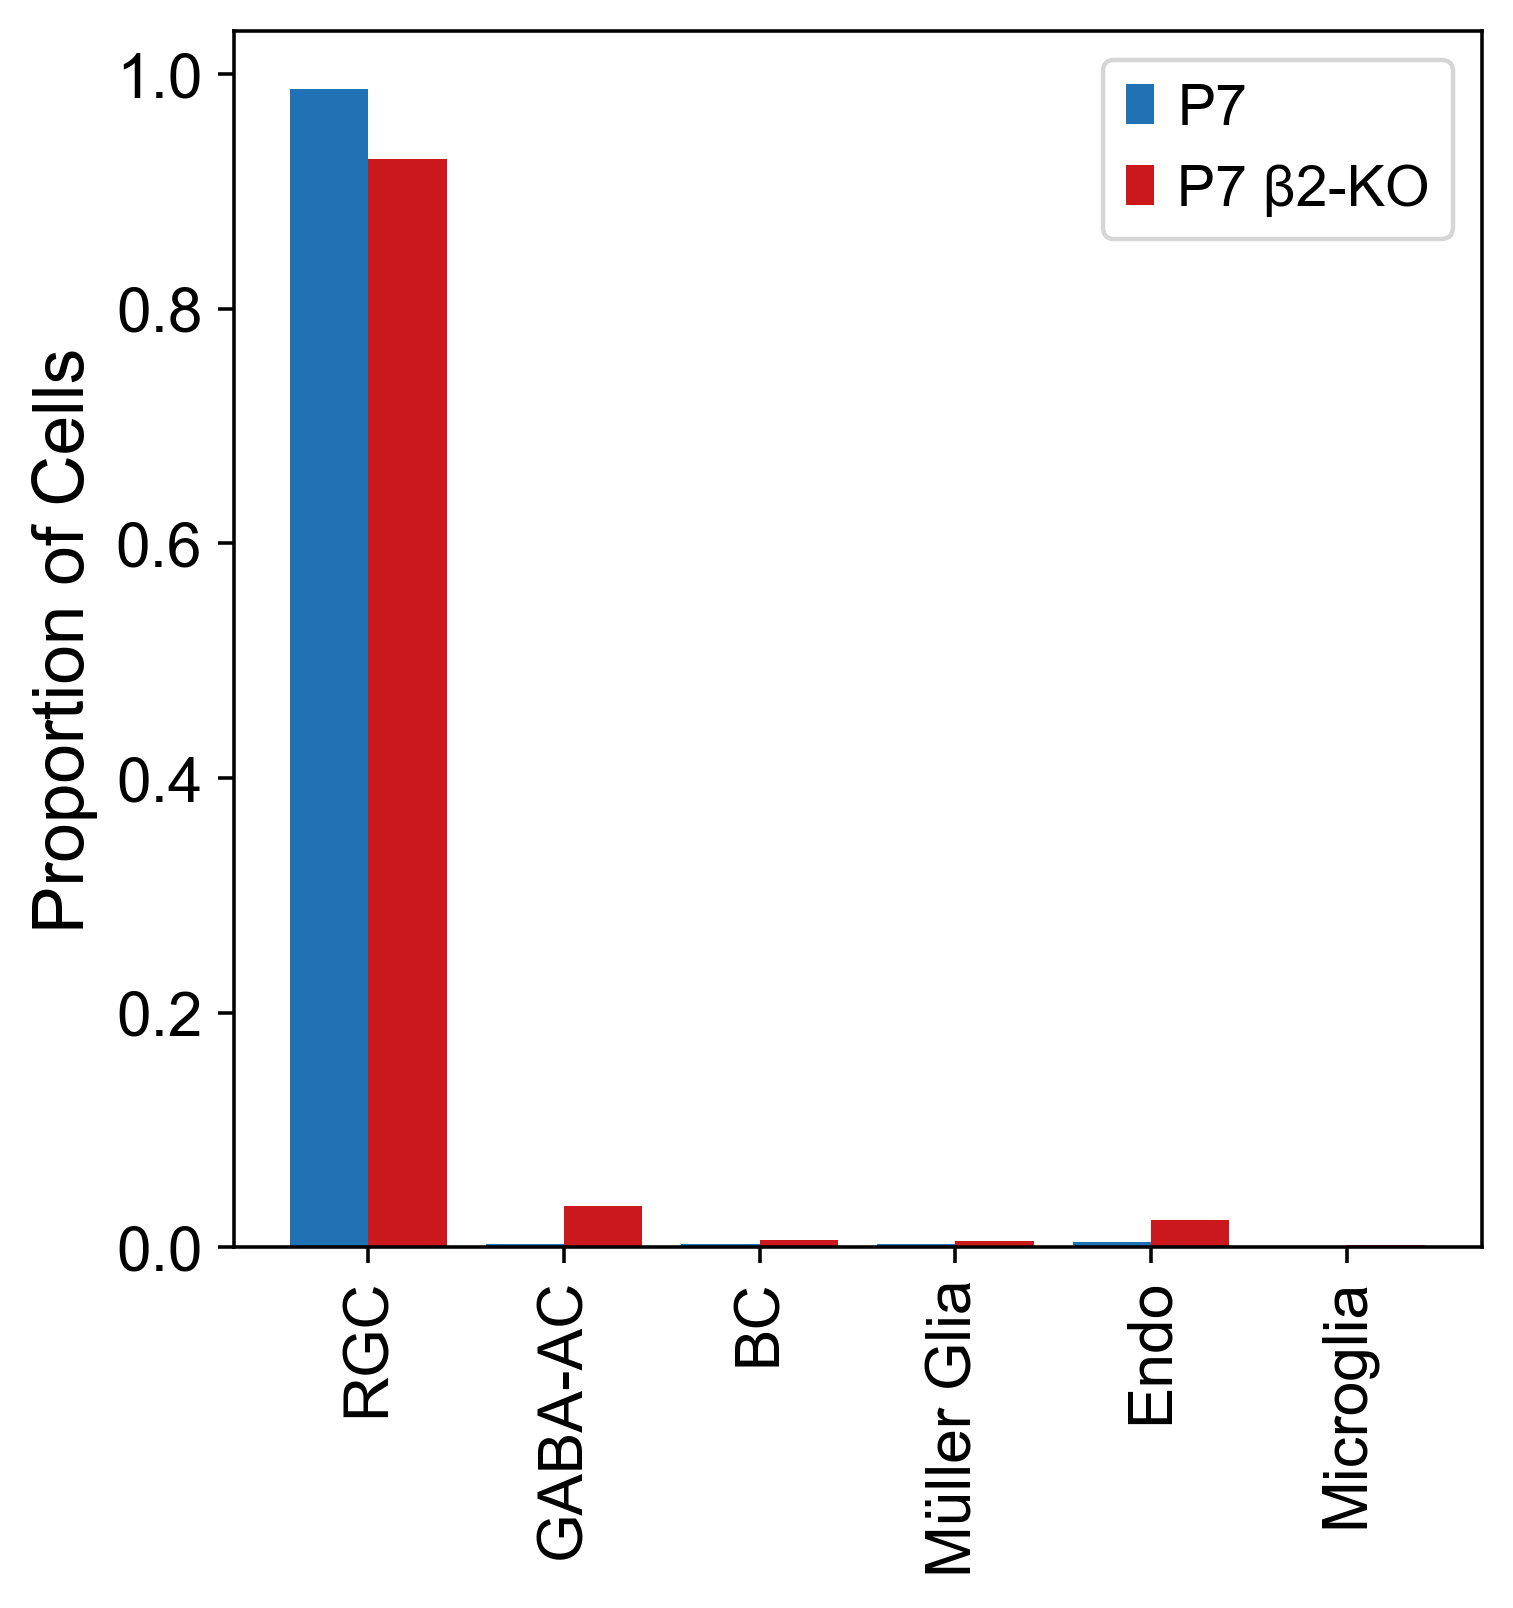

In [33]:
plt.subplots(figsize=(5,5))
plt.bar(np.arange(len(control_class_pcts))-0.2, control_class_pcts, width=0.4, color='#2171b5')
plt.bar(np.arange(len(b2_class_pcts))+0.2, b2_class_pcts, width=0.4, color='#cb181d')
plt.grid(False)
plt.xticks(np.arange(6), ['RGC', 'GABA-AC', 'BC', 'Müller Glia', 'Endo', 'Microglia'], rotation=90)
plt.ylabel('Proportion of Cells')
plt.legend(['P7', 'P7 β2-KO'])
plt.savefig('class_props.svg')